In [1]:
from tqdm.notebook import tqdm
from agent import Agent
from high_level_policy import HCBS
from map_handler import Map, read_map, read_tasks
from node import GridNode
import random
import glob
import os
import numpy as np
from low_level_policy import manhattan_distance, diagonal_distance
import tqdm
import matplotlib.pyplot as plt
np.random.seed(42)
random.seed(42)

In [2]:
A = read_tasks('output.scen')
N = 100

In [3]:
def simple_test(SearchFunction, height, width, mapstr, agents, diagonal_movements=False, **kwargs):
    task_map = Map()
    task_map.read_from_string(mapstr, width, height, diagonal_movements=diagonal_movements)
    return SearchFunction(task_map, agents, **kwargs)

In [4]:
def generate_sets_of_k(k, n_sets, filename):
    l = [ta for ta in A if filename in ta]
    result = set()
    while len(result) < n_sets:
        t = tuple(sorted(np.random.choice(range(len(l)), k, replace=False)))
        if t not in result:
            result.add(t)
    tasks = []
    for r in result:
        tasks += [[l[i] for i in r]]
    return tasks

In [5]:
%matplotlib inline
from IPython.display import clear_output
def massive_test(SearchFunction, map_dir, numbers_of_agents, title,diagonal_movements=False, **kwargs):
    results = {}
    map_files = glob.glob(os.path.join(map_dir, '*.map'))
    succ_rate = []
    for k in numbers_of_agents:
        results[k] = {}
        results[k]['success'] = []
        results[k]['ctnodes_created'] = []
        results[k]['time'] = []
        for map_file in map_files:
            mapstr = read_map(map_file)
            filename = os.path.basename(map_file)
            tasks = generate_sets_of_k(k, N, filename)

            for idx, task in enumerate(tasks):
                Agent.id = 0
                agents=[]
                for i in range(k):
                    bucket, path, map_width, map_height, jStart, iStart, jGoal, iGoal, length = task[i]
                    agents += [Agent(iStart, jStart, iGoal, jGoal)]
                sol = simple_test(SearchFunction, map_height, map_width, mapstr,
                                           agents, diagonal_movements=diagonal_movements, **kwargs)
                
                if sol:
                    results[k]['success'] += [True]
                    results[k]['ctnodes_created'] += [sol[0]]
                    results[k]['time'] += [sol[1]]
                else:
                    results[k]['success'] += [False]
                    results[k]['ctnodes_created'] += [np.nan]
                    results[k]['time'] += [np.nan]
#                 clear_output(True)
#                 print('{}; {}/{}; k={}'.format(os.path.basename(map_file),
                                             
#                                              idx, N ,k))
#                 rate = plt.scatter(numbers_of_agents[:len(succ_rate)], succ_rate, marker='x')
#                 plt.title("Success rate; {}".format(title))
#                 plt.show()
        succ_rate+=[np.nanmean(results[k]['success'])]
#         clear_output(True)
#         print('all tasks done')
#         rate = plt.scatter(numbers_of_agents[:len(succ_rate)], succ_rate, marker='x')
#         plt.title("Success rate; {}".format(title))
#         plt.show()
        #plt.legend(rate,'1', scatterpoints=1, ncol=3, fontsize=8)
    return results, succ_rate

In [ ]:
r = massive_test(HCBS, 'mapf-map-empty',  [2,4,8,12,16], "CBS+PC", diagonal_movements=False, 
                 heuristic_function=manhattan_distance, 
                 use_pc=True,
                 experiment_mode=True, max_time=300, verbose=False)
import pickle 

a_file = open("pc_8x8_empty.pkl", "wb")
pickle.dump(r, a_file)
a_file.close()

In [ ]:
r = massive_test(HCBS, 'mapf-map-empty', [2,4,8,12,16], "CBS", diagonal_movements=False, 
                 heuristic_function=manhattan_distance, 
                 use_pc=False,
                 experiment_mode=True, max_time=300, verbose=False)
import pickle 

a_file = open("no_pc_8x8_empty.pkl", "wb")
pickle.dump(r, a_file)
a_file.close()

In [9]:
r = massive_test(HCBS, 'mapf_map-room', [2,4,8,12,16], "CBS+PC", diagonal_movements=False,
                 heuristic_function=manhattan_distance, 
                 use_pc=True,
                 experiment_mode=True, max_time=300, verbose=False)
import pickle 

a_file = open("pc.pkl", "wb")
pickle.dump(r, a_file)
a_file.close()

In [10]:
r1 = massive_test(HCBS, 'mapf_map-room', [2,4,8,12,16], "CBS", diagonal_movements=False,
                 heuristic_function=manhattan_distance, 
                 use_pc=False,
                 experiment_mode=True, max_time=300, verbose=False)


a_file = open("no_pc.pkl", "wb")
pickle.dump(r1, a_file)
a_file.close()

In [12]:
with open("pc.pkl", "rb") as input_file:
    pc = pickle.load(input_file)

In [14]:
with open("no_pc.pkl", "rb") as input_file:
    cbs = pickle.load(input_file)

In [56]:
def generate_final_results(agent_values, cbs, pc):
    both_succeeded = {}
    for k in agent_values:
        both_succeeded[k] = np.array(pc[0][k]['success']) & np.array(cbs[0][k]['success'])
    cbs_pc_nodes={}
    cbs_pc_time={}
    cbs_nodes={}
    cbs_time={}
    for k in agent_values:
        cbs_pc_nodes[k] = np.mean(np.array(pc[0][k]['ctnodes_created'])[both_succeeded[k]])
        cbs_pc_time[k] = np.mean(np.array(pc[0][k]['time'])[both_succeeded[k]])
        cbs_nodes[k] = np.mean(np.array(cbs[0][k]['ctnodes_created'])[both_succeeded[k]])
        cbs_time[k] = np.mean(np.array(cbs[0][k]['time'])[both_succeeded[k]])
    return cbs_time, cbs_pc_time, cbs_nodes, cbs_pc_nodes, cbs[1], pc[1]
    

In [57]:
cbs_time, cbs_pc_time, cbs_nodes, cbs_pc_nodes, cbs_s, pc_s = generate_final_results([2,4,8,12,16], cbs, pc)

In [58]:
import pandas as pd
df = pd.DataFrame(pd.Series(cbs_time))
for d in [cbs_pc_time, cbs_nodes, cbs_pc_nodes]:
    df = pd.concat([df, pd.DataFrame(pd.Series(d))], axis=1)
df.columns = ['Время, с (CBC)', 'Время, с (CBC+PC)', 'CTNodes (CBS)', 'CTNodes (CBS+PC)']
df

,"Время, с (CBC)","Время, с (CBC+PC)",CTNodes (CBS),CTNodes (CBS+PC)
2,0.038587,0.047440,1.440000,1.440000
4,1.289318,0.636122,6.414141,3.484848
8,2.362520,2.004964,53.888889,18.088889
12,19.550481,15.655129,263.782609,103.188406
16,50.341116,30.231400,1233.125000,251.093750


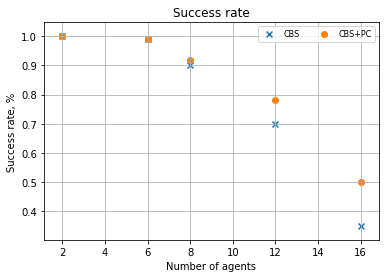

In [62]:
cbs_plot = plt.scatter([2,6,8,12,16], cbs_s, marker='x')
pc_plot = plt.scatter([2,6,8,12,16], pc_s, marker='o')
plt.title("Success rate")
plt.grid()
plt.xlabel('Number of agents')
plt.ylabel('Success rate, %')
plt.legend((cbs_plot, pc_plot), ('CBS','CBS+PC'), scatterpoints=1, ncol=3, fontsize=8)
plt.show()

In [64]:
with open("pc_8x8_empty.pkl", "rb") as input_file:
    pc = pickle.load(input_file)
with open("no_pc_8x8_empty.pkl", "rb") as input_file:
    cbs = pickle.load(input_file)
cbs_time, cbs_pc_time, cbs_nodes, cbs_pc_nodes, cbs_s, pc_s = generate_final_results([2,4,8,12,16], cbs, pc)

df = pd.DataFrame(pd.Series(cbs_time))
for d in [cbs_pc_time, cbs_nodes, cbs_pc_nodes]:
    df = pd.concat([df, pd.DataFrame(pd.Series(d))], axis=1)
df.columns = ['Время, с (CBC)', 'Время, с (CBC+PC)', 'CTNodes (CBS)', 'CTNodes (CBS+PC)']
df


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,"Время, с (CBC)","Время, с (CBC+PC)",CTNodes (CBS),CTNodes (CBS+PC)
2,0.000108,0.000141,1.081633,1.081633
4,0.005890,0.010502,8.000000,8.000000
8,0.005761,0.010414,9.454545,9.636364
12,0.012853,0.023692,19.000000,19.000000
16,NaN,NaN,NaN,NaN


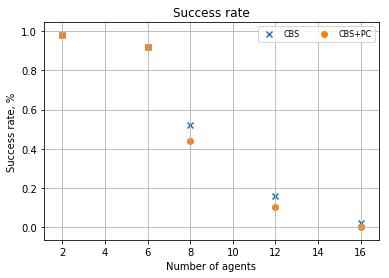

In [65]:
cbs_plot = plt.scatter([2,6,8,12,16], cbs_s, marker='x')
pc_plot = plt.scatter([2,6,8,12,16], pc_s, marker='o')
plt.title("Success rate")
plt.grid()
plt.xlabel('Number of agents')
plt.ylabel('Success rate, %')
plt.legend((cbs_plot, pc_plot), ('CBS','CBS+PC'), scatterpoints=1, ncol=3, fontsize=8)
plt.show()